# Figures 3-4

This notebook produces Figures 3-4 and other auxiliary figures.       

## Get data

(1) from Felikson et al.: Inland limits to diffusion of thinning along Greenland Ice Sheet outlet glaciers, available at https://zenodo.org/record/4284759. Redistributed under the CC-BY-4.0 License (see the previous link for details).

Reference: Felikson, D., A. Catania, G., Bartholomaus, T. C., Morlighem, M., & Noël, B. P. Y. (2021). Steep Glacier Bed Knickpoints Mitigate Inland Thinning in Greenland. Geophysical Research Letters, 48(2), 1–10. https://doi.org/10.1029/2020GL090112

In [2]:
%%bash

if [ ! -d ../data/Felikson2021/ ]; then
    wget https://zenodo.org/record/4284759/files/netcdfs.zip -P ../data/Felikson2021/ --no-verbose
    unzip ../data/Felikson2021/netcdfs.zip -d ../data/Felikson2021/
    rm -rf ../data/Felikson2021/netcdfs.zip
fi

(2) From ITS_LIVE: A NASA MEaSUREs project to provide automated, low latency, global glacier flow and elevation change datasets. Original data available at https://its-live.jpl.nasa.gov/. We manually made the file for the 2018-1998 speed difference.

References: 

1. Gardner, A. S., M. A. Fahnestock, and T. A. Scambos (2019) [Accessed October 21, 2021]. ITS_LIVE Regional Glacier and Ice Sheet Surface Velocities. Data archived at National Snow and Ice Data Center. https://doi.org/10.5067/6II6VW8LLWJ7
2. Gardner, A. S., G. Moholdt, T. Scambos, M. Fahnstock, S. Ligtenberg, M. van den Broeke, and J. Nilsson (2018). Increased West Antarctic and unchanged East Antarctic ice discharge over the last 7 years, Cryosphere, 12(2), 521–547. https://doi.org/10.5194/tc-12-521-2018

In [3]:
%%bash

if [ ! -f ../data/GRE_G0240_1998_v.tif ]; then
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/GRE_G0240_1998_v.tif -P ../data/ --no-verbose
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/GRE_G0240_diff-2018-1998_v.tif -P ../data/ --no-verbose
fi

## Analysis

In [4]:
import pejzero
import rasterio
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

File locations. You can replace the number in `/glacier0207.nc` for processing other glacier data. In the paper, **Figure 3** uses `/glacier0207.nc` and **Figure 4** uses `/glacier0277.nc`.

In [23]:
netcdf_dir = '../data/Felikson2021'
glacier_file = netcdf_dir + '/glacier0277.nc'
speed_file = '../data/GRE_G0240_1998_v.tif'
vdiff_file = '../data/GRE_G0240_diff-2018-1998_v.tif'

In [24]:
if '0001' in glacier_file:
    fig_label = 'glacier 0001: Jakobshavn Isbræ'
elif '0277' in glacier_file:
    fig_label = 'glacier 0277: Alangordliup Sermia'
else:
    fig_label = Path(glacier_file).stem

Open the data set and show 6 primary flowlines.

In [25]:
ds = Dataset(glacier_file, 'r')
flowline_groups, _ = pejzero.get_flowline_groups(ds)
primary_flowlines = [i for i in flowline_groups if 'iter' not in i.path]
primary_flowlines
# Here's how to access variables in the primary_flowlines object:
# primary_flowlines[0]['geometry']['surface']['GIMP']['nominal']['h'][:]

[<class 'netCDF4._netCDF4.Group'>
 group /flowline03:
     dimensions(sizes): d(12402)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline04:
     dimensions(sizes): d(12519)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline05:
     dimensions(sizes): d(12501)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline06:
     dimensions(sizes): d(12455)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline07:
     dimensions(sizes): d(12420)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <cla

Calculate $P_e/\ell$ and $J_0$ for each flowline, and calculate the average of all 6 flowlines: 

In [26]:
results = {}

with rasterio.open(speed_file) as speed_data, rasterio.open(vdiff_file) as vdiff_data:
    for flowline_group in primary_flowlines:
        data_group = pejzero.cal_pej0_for_each_flowline(flowline_group, speed_data, vdiff_data)
        if data_group is not None:
            results[flowline_group.name] = data_group
        
results['avg'] = pejzero.cal_avg_for_each_basin(results)

In [27]:
for key in results:
    print(key)

flowline03
flowline04
flowline05
flowline06
flowline07
flowline08
avg


Now we can plot **Figure 3**:

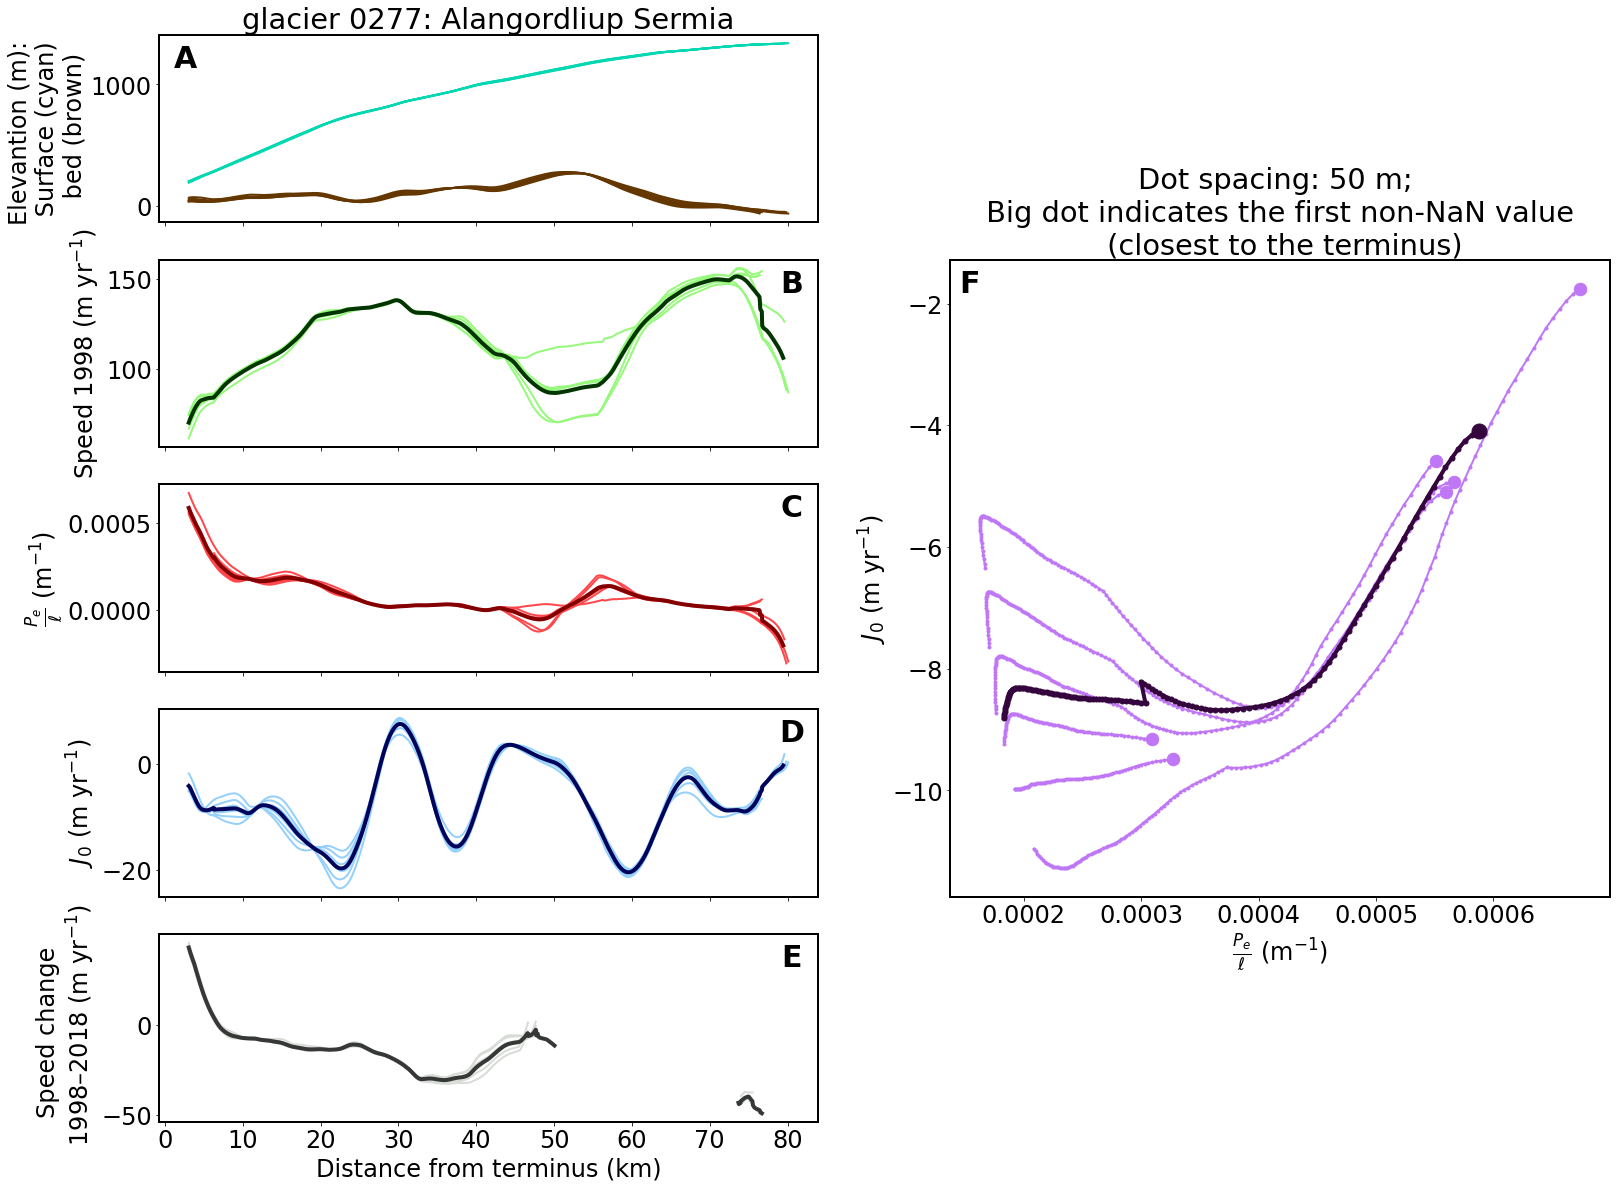

In [28]:
pej0_plot_length = 200   # This determines how many vertices from the terminus should be plotted (200 vertices = 10 km)

matplotlib.rc('font', size=24)
matplotlib.rc('axes', linewidth=2)

# ==== Create axes (5 in the left and a big one in the right)
fig, ax3 = plt.subplots(5, 2, sharex=True, figsize=(26, 20))
gs = ax3[1, 1].get_gridspec()
for ax in ax3[:, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[1:4, 1])

# ==== Plot data
for key in results:
    
    if key != 'avg':
        ax3[0, 0].plot(results[key]['d'], results[key]['s'], color='xkcd:aquamarine', linewidth=2)
        ax3[0, 0].plot(results[key]['d'], results[key]['b'], color='xkcd:brown', linewidth=2)
        ax3[1, 0].plot(results[key]['d'], results[key]['u'], color='xkcd:light green', linewidth=2)
        ax3[2, 0].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:light red', linewidth=2)
        ax3[3, 0].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:light blue', linewidth=2)
        ax3[4, 0].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:light grey', linewidth=2)
        axbig.plot(results[key]['pe_ignore_dslope'][:pej0_plot_length], results[key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:light purple', linewidth=2)
        # plot first non-NaN value (the one closest to the terminus)
        axbig.plot(next(x for x in results[key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                   next(x for x in results[key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:light purple', markersize=25)
    else:
        ax3[1, 0].plot(results[key]['d'], results[key]['u'], color='xkcd:dark green', linewidth=4)
        ax3[2, 0].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:dark red', linewidth=4)
        ax3[3, 0].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:dark blue', linewidth=4)
        ax3[4, 0].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:dark grey', linewidth=4)
        axbig.plot(results[key]['pe_ignore_dslope'][:pej0_plot_length], results[key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:dark purple', linewidth=4, markersize=10)
        # plot first non-NaN value (the one closest to the terminus)
        axbig.plot(next(x for x in results[key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                   next(x for x in results[key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:dark purple', markersize=30)
        
# ==== Add supplemental text 
letter_specs = {'fontsize': 30, 'fontweight': 'bold', 'va': 'top', 'ha': 'center'}
ax3[0, 0].set_title(fig_label)
ax3[0, 0].set_ylabel('Elevantion (m): \n Surface (cyan) \n bed (brown)')
ax3[0, 0].text(0.04, 0.95, 'A', transform=ax3[0, 0].transAxes, **letter_specs)
ax3[1, 0].set_ylabel('Speed 1998 (m yr$^{-1}$)')
ax3[1, 0].text(0.96, 0.95, 'B', transform=ax3[1, 0].transAxes, **letter_specs)
ax3[2, 0].set_ylabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
ax3[2, 0].text(0.96, 0.95, 'C', transform=ax3[2, 0].transAxes, **letter_specs)
ax3[3, 0].set_ylabel(r'$J_0$ (m yr$^{-1}$)')
ax3[3, 0].text(0.96, 0.95, 'D', transform=ax3[3, 0].transAxes, **letter_specs)
ax3[4, 0].set_xlabel('Distance from terminus (km)')
ax3[4, 0].set_ylabel('Speed change \n 1998–2018 (m yr$^{-1}$)')
ax3[4, 0].text(0.96, 0.95, 'E', transform=ax3[4, 0].transAxes, **letter_specs)
axbig.set_xlabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
axbig.set_ylabel(r'$J_0$ (m yr$^{-1}$)')
axbig.set_title('Dot spacing: 50 m; \n Big dot indicates the first non-NaN value \n (closest to the terminus)')
axbig.text(0.03, 0.985, 'F', transform=axbig.transAxes, **letter_specs)
if fig_label == 'glacier 0001: Jakobshavn Isbræ':
    axbig.set_xticks([-0.00015, -0.0001, -0.00005, 0])
    ax3[4, 0].set_xlim(0, 80)

plt.savefig('../data/results/' + Path(glacier_file).stem + '.pdf')

To run the analysis in a batch mode for more than one glacier, uncomment the following cell using `Pe-J0-Greenland-SingleBasin.py`. The default setting prints PNG files but can be switched to pdf easily.

In [9]:
# %%bash

# filelist=`ls --color=never ../data/Felikson2021/*`
# for i in $filelist; do 
#     python Pe-J0-Greenland-SingleBasin.py $i
# done

In [14]:
results['avg']['j0_ignore_dslope']

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  